In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division

In [2]:
import sys
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
import tensorflow as tf
import numpy as np
from ops import *
import sampler

In [4]:
# generator feed length
gf_dim = 128
with tf.variable_scope('Generator') as scope:
    z = tf.placeholder(dtype=tf.float32, shape=[None, gf_dim])
    h0 = linear(z, out_dim=gf_dim*8 * 2*2)
    shaped = tf.reshape(h0, [-1, 2, 2, gf_dim*8])
    
    h1 = conv_trans(shaped, depth=gf_dim*4, kernel_size=5, pad=[2,1])
    h1 = tf.nn.relu(h1)
    
    h2 = conv_trans(h1, depth=gf_dim*2, kernel_size=5, pad=[2,1])
    h2 = tf.nn.relu(h2)
    
    h3 = conv_trans(h2, depth=gf_dim*1, kernel_size=5, pad=[2,1])
    h3 = tf.nn.relu(h3)
    
    G = conv_trans(h3, depth=3, kernel_size=5, pad=[4,5])
    G = tf.nn.tanh(G)
    
    


In [5]:
print(h1, h2, h3, G, sep="\n")

Tensor("Generator/Relu:0", shape=(?, 10, 10, 512), dtype=float32)
Tensor("Generator/Relu_1:0", shape=(?, 26, 26, 256), dtype=float32)
Tensor("Generator/Relu_2:0", shape=(?, 58, 58, 128), dtype=float32)
Tensor("Generator/Tanh:0", shape=(?, 128, 128, 3), dtype=float32)


In [6]:
for v in tf.trainable_variables(): print(v)

Tensor("Generator/linear/Variable/read:0", shape=(128, 4096), dtype=float32)
Tensor("Generator/linear/Variable_1/read:0", shape=(4096,), dtype=float32)
Tensor("Generator/conv_trans/Variable/read:0", shape=(5, 5, 512, 1024), dtype=float32)
Tensor("Generator/conv_trans/Variable_1/read:0", shape=(512,), dtype=float32)
Tensor("Generator/conv_trans_1/Variable/read:0", shape=(5, 5, 256, 512), dtype=float32)
Tensor("Generator/conv_trans_1/Variable_1/read:0", shape=(256,), dtype=float32)
Tensor("Generator/conv_trans_2/Variable/read:0", shape=(5, 5, 128, 256), dtype=float32)
Tensor("Generator/conv_trans_2/Variable_1/read:0", shape=(128,), dtype=float32)
Tensor("Generator/conv_trans_3/Variable/read:0", shape=(5, 5, 3, 128), dtype=float32)
Tensor("Generator/conv_trans_3/Variable_1/read:0", shape=(3,), dtype=float32)


In [7]:
real_images = sampler.DataSampler(image_size=128, pre_load=False)

In [19]:
latent_feeder = sampler.LatentSampler(mean=0, variance=0, shape=[128])

ok
eval ok


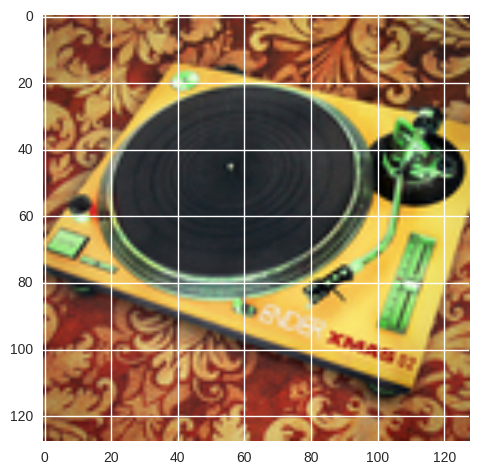

In [20]:
test_im = real_images.tensorflow_next_batch(10, 2)

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        print('ok')
        im = sess.run(test_im)
        print('eval ok')
        plt.imshow(im[0])

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()

# Train the generator to simply reproduce real images, on its own

In [22]:
with tf.Session() as sess:
    ITER = 1000
    BATCH_SIZE = 64
    
    target_feed = real_images.tensorflow_next_batch(BATCH_SIZE)
    latent_feed = latent_feeder.next_batch(BATCH_SIZE)
    target = tf.placeholder(dtype=tf.float32)
    G_pre_loss = tf.reduce_mean(tf.square(target - G))
    opt = tf.train.MomentumOptimizer(learning_rate=0.0002, momentum=0.5)
    opt = opt.minimize(G_pre_loss)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tf.global_variables_initializer().run()
    
    loss_log = []
    try:
        for i in xrange(ITER):
            l, _ = sess.run([G_pre_loss, opt], {z: latent_feed, target: target_feed.eval()})
            loss_log.append(l)

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    # Wait for threads to finish.
    coord.join(threads)
    sess.close()
    
    

InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 5, computed = 3
	 [[Node: Generator/conv_trans/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Generator/conv_trans/conv2d_transpose/output_shape, Generator/conv_trans/Variable/read, Generator/conv_trans/Pad)]]

Caused by op u'Generator/conv_trans/conv2d_transpose', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-7e0c7e190837>", line 8, in <module>
    h1 = conv_trans(shaped, depth=gf_dim*4, kernel_size=5, pad=[2,1])
  File "ops.py", line 77, in conv_trans
    padding='VALID')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 1078, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 489, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 5, computed = 3
	 [[Node: Generator/conv_trans/conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Generator/conv_trans/conv2d_transpose/output_shape, Generator/conv_trans/Variable/read, Generator/conv_trans/Pad)]]


# conv2d_transpose problem

Workaround with StackOverflow solution:
http://stackoverflow.com/questions/35488717/confused-about-conv2d-transpose

In [26]:
sess = tf.Session()
batch_size = 3
output_shape = [batch_size, 8, 8, 128]
strides = [1, 2, 2, 1]

l = tf.constant(0.1, shape=[batch_size, 32, 32, 4])
w = tf.constant(0.1, shape=[7, 7, 128, 4])

h1 = tf.nn.conv2d_transpose(l, w, output_shape=output_shape, strides=strides, padding='SAME')
print(sess.run(h1))

InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 32, computed = 4
	 [[Node: conv2d_transpose_2 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose_2/output_shape, Const_5, Const_4)]]

Caused by op u'conv2d_transpose_2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python2.7/dist-packages/tornado/ioloop.py", line 866, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-d252c224e6ad>", line 9, in <module>
    h1 = tf.nn.conv2d_transpose(l, w, output_shape=output_shape, strides=strides, padding='SAME')
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_ops.py", line 1078, in conv2d_transpose
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 489, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 32, computed = 4
	 [[Node: conv2d_transpose_2 = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose_2/output_shape, Const_5, Const_4)]]


In [33]:
output = tf.constant(0.1, shape=output_shape)
expected_l = tf.nn.conv2d(output, w, strides=[1,1,1,1], padding='VALID')
print(expected_l.get_shape())
# Prints (3, 4, 4, 4)

(3, 2, 2, 4)


# ORIGINAL DCGAN SHAPE

### CONV shape: **stride=2, kernel=5**

* 4, 4, 1024

CONV1

* 8, 8, 512

CONV2

* 16, 16, 256

CONV3

* 32, 32, 128

CONV4

* 64, 64, 3

### WHAT PADDING?

#### Formula for output shape of convolution:
$$W_{out} = \frac{W_{in} - K + 2P}{S} + 1$$
#### Transposed convolution:
$$W_{in}=(W_{out}-1)\cdot S + K - 2P$$
#### Padding:
$$2P = (W_{out}-1)\cdot S + K - W_{in}$$

Since `conv2d_transpose()` is using the reversed operation of `conv2d()`, we can compute, how the input should be shaped of the layer, to get the fixed result

In [37]:
def get_expected_input_shape(output):
    sess = tf.Session()
    batch_size = 3
    output_shape = [batch_size, output, output, 512]
    strides = [1, 2, 2, 1]
    w = tf.constant(0.1, shape=[5, 5, 512, 1024])
    output = tf.constant(0.1, shape=output_shape)
    expected_in = tf.nn.conv2d(output, w, strides=strides, padding='SAME')
    return expected_in.get_shape()

In [40]:
get_expected_input_shape(64)

TensorShape([Dimension(3), Dimension(32), Dimension(32), Dimension(1024)])

#### Formula for output shape of convolution:
$$W_{out} = \frac{W_{in} - K + 2P}{S} + 1$$
#### Transposed convolution:
$$W_{in}=(W_{out}-1)\cdot S + K - 2P$$
#### Padding:
$$2P = (W_{out}-1)\cdot S + K - W_{in}$$

#### Substituing in
$$W_{out} = \frac{64 - 5 + 2P}{2} + 1$$
$$W_{in}=(32-1)\cdot 2 + 5 - 2P$$
$$2P = (32-1)\cdot 2 + 5 - 64 = 3$$

**TF requires an extra operation `tf.pad()` to explicitly use padding, because conv2d only has padding options 'SAME' and 'VALID'**

However knowing that `conv2d_transpose()` will use `conv2d` padding, I try to leave it to TF

In [56]:
def test_forwarding(in_w, out_w):
    sess = tf.Session()
    batch_size = 3
    
    strides = [1, 2, 2, 1]
    in_layer = tf.constant(0.1, shape=[batch_size, in_w, in_w, 4])
    
    # The kernel shape order is also using the conv2d order
    # i.e. [K_w, K_h, D_out, D_in]
    # Notice that in conv2d_transpose the order is
    # [K_w, K_h, D_in, D_out]
    w = tf.constant(0.1, shape=[2, 2, 128, 4])

    # conv2d_transpose requires explicit output shape definition
    output_shape = [batch_size, out_w, out_w, 128]
    out = tf.nn.conv2d_transpose(in_layer, w, output_shape=output_shape, strides=strides, padding='SAME')
    return out

In [57]:
with tf.Session() as sess:
    print(test_forwarding(15, 30).eval().shape)

(3, 30, 30, 128)


# WORKING! WOOHOO

If I put in the dimensions which I have checked the expected dimensions, then actual numbers come out of TF... Which is, in general a good thing.

## CONCLUSION

If we can get along with conv2d **'SAME'** padding method then the following equations determine the output shape

$$W_{in}=\frac{W_{out}}{S}$$

**REGARDLESS THE SHAPE OF THE KERNEL!!**

$$W_{out}=W_{in} \cdot S $$


Testing the new ops implementation: (kernel refresh)

In [4]:
in_layer = tf.constant(1.0, shape=[7, 4, 4, 1024])
op = conv_T(in_layer, depth=512, kernel_size=5)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(op.eval().shape)

(7, 8, 8, 512)


# YISS!

Now try again with generator

In [6]:
gf_dim = 128
with tf.variable_scope('Generator') as scope:
    z = tf.placeholder(dtype=tf.float32, shape=[None, gf_dim])
    
    h0 = linear(z, out_dim=gf_dim*8 * 2*2)
    h0 = tf.reshape(h0, [-1, 2, 2, gf_dim*8])
    
    h1 = conv_T(h0, depth=gf_dim*4, kernel_size=5)
    h1 = tf.nn.relu(h1)
    
    h2 = conv_T(h1, depth=gf_dim*2, kernel_size=5)
    h2 = tf.nn.relu(h2)
    
    h3 = conv_T(h2, depth=gf_dim*1, kernel_size=5)
    h3 = tf.nn.relu(h3)
    
    G = conv_T(h3, depth=3, kernel_size=5)
    G = tf.nn.relu(G)

In [7]:
G.get_shape()

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(3)])

In [8]:
latent_feeder = sampler.LatentSampler(mean=.5, variance=.1, shape=[128])
# Testing the TensorFlow reader
tf_reader = sampler.DataSampler(image_size=32, pre_load=True)


Reading dataset from source... 1369/1369

3 Loss:  0.168938
6 Loss:  0.204206
9 Loss:  0.0809913
12 Loss:  0.273978
15 Loss:  0.214265
18 Loss:  0.130164
21 Loss:  0.16615
24 Loss:  0.160956
27 Loss:  0.104845
30 Loss:  0.232732
(1, 32, 32, 3)


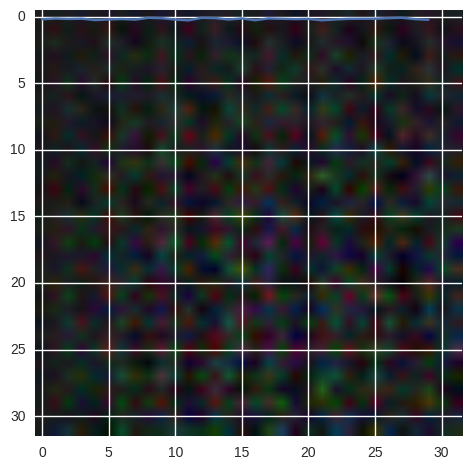

In [10]:
with tf.Session() as sess:
    ITER = 30
    BATCH_SIZE = 8
    
    target_feed = tf_reader.tensorflow_next_batch(BATCH_SIZE)
    latent_feed = latent_feeder.next_batch(BATCH_SIZE)
    target = tf.placeholder(dtype=tf.float32)
    G_pre_loss = tf.reduce_mean(tf.square(target - G))
    opt = tf.train.MomentumOptimizer(learning_rate=0.00002, momentum=0.5)
    opt = opt.minimize(G_pre_loss)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tf.global_variables_initializer().run()
    
    loss_log = []
    try:
        for i in xrange(ITER):
            l, _ = sess.run([G_pre_loss, opt], {z: latent_feed, target: target_feed.eval()})
            loss_log.append(l)
            if (i+1) % (ITER//10)  == 0:
                print(i+1, 'Loss: ', l)

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()

    
    #plt.plot(loss_log)
    test_im = G.eval({z:latent_feeder.next_batch(1)})
    print(test_im.shape)
    plt.imshow(test_im.squeeze())
        
    # Wait for threads to finish.
    coord.join(threads)
    sess.close()
    

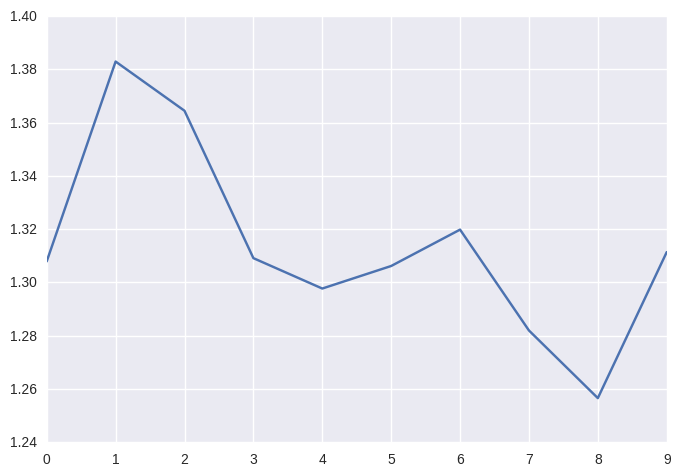

In [14]:
plt.plot(loss_log)

In [ ]:
tf.add()